<h1>Final Project: Seinfeld - Social Network Analysis</h1>

<h3> DATA 620 Web Analytics, CUNY Spring 2018 </h3>

Team: Andy Carson, Nathan Cooper, Walt Wells

Notebooks:

Video: 

Proposal:

<h2>Project Requirements</h2>

Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as a Jupyter Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters. 


<h2>Project Solution: Social Network Analysis</h2>
<ol>
    <li>SNA of Actors / Characters by Season</li>
    <ol>
        <li>Projected actors/characters by season</li>
        <li>Projected season by actors/characters</li>
    </ol>
    <li>SNA of Character by Scene Number (scenes together)</li>
    <ol>
        <li>Projected character by scene</li>
    </ol>
    <li>SNA of Directors by Season</li>
        <ol>
        <li>Projected Directors by Season</li>
        <li>Projected Season by Directors</li>
        </ol>
    <li>SNA of Writers by Season</li>
    <ol>
        <li>Projected writers by Season</li>
        <li>Projected Season by writers</li>
    </ol>
    <li>SNA of writers to directors to cast</li>
    <ol>
        <li>Using season/episode to join</li>
        <li>Project directors by writer</li>
        <li>Project writers by director</li>
        <li>Project directors by writer</li>
        <li>Project cast by directors</li>
        <li>Project cast by writers</li>
    </ol>
</ol>



In [1]:
import networkx as nx #note: this is version 2.1
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from networkx.algorithms import bipartite as bi
import math
import re

plt.figure(figsize = (17,8))
% matplotlib inline

<h2> Read In Data</h2>

Pull in pre-processed and cleaned data from GitHub.

In [2]:
#read in data
sf_cast = pd.read_csv("https://raw.githubusercontent.com/wwells/CUNY_DATA_620_GROUP/master/Final_Project/Data/Seinfield_Cast.csv")
sf_dialogue = pd.read_csv("https://raw.githubusercontent.com/wwells/CUNY_DATA_620_GROUP/master/Final_Project/Data/Seinfield_Dialogue.csv")
sf_dialgoue_sub = pd.read_csv("https://raw.githubusercontent.com/wwells/CUNY_DATA_620_GROUP/master/Final_Project/Data/Seinfield_DialogueSUBSET.csv")
sf_metadata = pd.read_csv("https://raw.githubusercontent.com/wwells/CUNY_DATA_620_GROUP/master/Final_Project/Data/Seinfield_Metadata.csv")
sf_writers = pd.read_csv("https://raw.githubusercontent.com/wwells/CUNY_DATA_620_GROUP/master/Final_Project/Data/Seinfield_Writers.csv")

In [3]:
sf_cast.head(5)

,Actor,Character,SEID
0,Jerry Seinfeld,Jerry Seinfeld,S01E00
1,Jason Alexander,George Costanza,S01E00
2,Michael Richards,Kessler,S01E00
3,Lee Garlington,Claire,S01E00
4,Pamela Brull,Laura,S01E00


In [4]:
sf_dialogue.head(5)

,Character,Dialogue,DialogueIndex,SEID,SceneNum
0,JERRY,Do you know what this is all about? Do you kno...,1,S01E00,S01E00_1
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1,S01E00,S01E00_2
2,GEORGE,Are you through?,2,S01E00,S01E00_2
3,JERRY,"You do of course try on, when you buy?",3,S01E00,S01E00_2
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",4,S01E00,S01E00_2


In [5]:
sf_dialgoue_sub.head(5)

,Character,Dialogue,DialogueIndex,SEID,SceneNum
0,JERRY,Do you know what this is all about? Do you kno...,1,S01E00,S01E00_1
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1,S01E00,S01E00_2
2,GEORGE,Are you through?,2,S01E00,S01E00_2
3,JERRY,"You do of course try on, when you buy?",3,S01E00,S01E00_2
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",4,S01E00,S01E00_2


In [6]:
sf_metadata.head(5)

,AirDate,Director,Episode,SEID,Season,Title
0,"July 5, 1989",Art Wolff,1,S01E00,1,"Good News, Bad News"
1,"May 31, 1990",Tom Cherones,1,S01E01,1,The Stakeout
2,"June 7, 1990",Tom Cherones,2,S01E02,1,The Robbery
3,"June 14, 1990",Tom Cherones,3,S01E03,1,Male Unbonding
4,"June 21, 1990",Tom Cherones,4,S01E04,1,The Stock Tip


In [7]:
sf_writers.head(5)

,Writers,SEID
0,Larry David,S01E00
1,Jerry Seinfeld,S01E00
2,Larry David,S01E01
3,Jerry Seinfeld,S01E01
4,Matt Goldman,S01E02


<h2>Functions </h2>

In [8]:
def centrality_measures(g):
    print "Number of Nodes:"
    print g.number_of_nodes()
    print
    
    print "Number of Edges:"
    print g.number_of_edges()
    print
    
    degree = nx.degree(g)
    degree = dict(list(degree))
    sort_degree = sorted(degree.iteritems(), key=lambda(k,v): (-v,k))
    print "Degree:"
    print sort_degree[0:10]
    print
    
    closeness = nx.closeness_centrality(g)
    print "Closeness:"
    print sorted(closeness.iteritems(), key=lambda(k,v): (-v,k))[0:10]
    print
    
    betweenness = nx.betweenness_centrality(g)
    print "Betweenness:"
    print sorted(betweenness.iteritems(), key=lambda(k,v): (-v,k))[0:10]
    print
    
    eigenvector = nx.eigenvector_centrality(g)
    print "Eigenvector:"
    print sorted(eigenvector.iteritems(), key=lambda(k,v): (-v,k))[0:10]
    print
    
    pagerank = nx.pagerank(g)
    print "Pagerank:"
    print sorted(pagerank.iteritems(), key=lambda(k,v): (-v,k))[0:10]

In [9]:
def make_draw_graph(graphName, node_values,df, labels):
    #make graph
    g = nx.Graph(name = graphName)
    
    #get nodes
    g.add_nodes_from(node_values)
    
    #get edges
    edges_tuples = [tuple(x) for x in df.values]
    g.add_weighted_edges_from(edges_tuples)
    
    #weight the data for edge width and coloring.  Code borrowed and modified from SNA.
    weights = [float(edata['weight']) for f, t, edata in g.edges(data=True)]
    
    #draw graph
    nx.draw_spring(g, with_labels=labels, width = weights, edge_color = weights)
    
    return g
    

In [10]:
#####
## islands method
# taken from SNA chp 4 pg 64.  Modified appropriately.
########

def trim_edges(g, weight = 1):
    edges = []
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight']> weight:
            x = float(edata['weight'])
            edges.append((f,to,x))
    g2.add_weighted_edges_from(edges)
    return g2


def island_method(g, iterations=5):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    
    #size of step
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn, mx, step)]

In [11]:
def print_island_info(island):
    print "Threshold, Nodes, Edges, Number of Connected Components"
    for i in island:
        print i[0], nx.number_of_nodes(i[1]), nx.number_of_edges(i[1]), nx.number_connected_components(i[1])

In [12]:
def show_island_graphs(g_island,threshold,labels):
    g_weights = [math.log(float(edata['weight'])) for f, t, edata in g_island[threshold][1].edges(data=True)]
    nx.draw_spring(g_island[threshold][1], width=g_weights, edge_color=g_weights, with_labels=labels)

In [13]:
def make_draw_projected_graph(g, labels):
    weights_graph = [float(edata['weight']) for f, t, edata in g.edges(data=True)]
    nx.draw_spring(g, width=weights_graph, edge_color=weights_graph, with_labels=labels)

<h2> 1. Actor / Character and Season </h2>

In [14]:
sf_cast.head(5)

,Actor,Character,SEID
0,Jerry Seinfeld,Jerry Seinfeld,S01E00
1,Jason Alexander,George Costanza,S01E00
2,Michael Richards,Kessler,S01E00
3,Lee Garlington,Claire,S01E00
4,Pamela Brull,Laura,S01E00


In [15]:
#reference: https://pandas.pydata.org/pandas-docs/stable/10min.html
sf_cast_episode = pd.DataFrame(sf_cast['SEID'].str.split("E").tolist(), columns = ['season','episode'])
sf_cast = sf_cast.join(sf_cast_episode)

In [16]:
sf_cast.head(5)

,Actor,Character,SEID,season,episode
0,Jerry Seinfeld,Jerry Seinfeld,S01E00,S01,00
1,Jason Alexander,George Costanza,S01E00,S01,00
2,Michael Richards,Kessler,S01E00,S01,00
3,Lee Garlington,Claire,S01E00,S01,00
4,Pamela Brull,Laura,S01E00,S01,00


In [17]:
sf_cast_group = sf_cast.groupby(['Actor','season'], as_index=False).count()
sf_cast_group = sf_cast_group[['Actor','season', 'episode']]
sf_cast_group.columns = ['Actor','season', 'Counts']

In [18]:
sf_cast_group.head(5)

,Actor,season,Counts
0,A.J. Langer,S08,1
1,Aaron Kanarek,S03,1
2,Adam Leslie,S03,1
3,Adam Wylie,S03,1
4,Adelaide Miller,S06,1


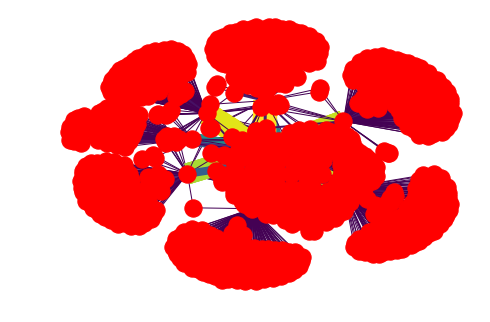

In [20]:
#draw actor and season graph
characters_season = make_draw_graph("Actors and Season", list(sf_cast_group.Actor.values) + list(sf_cast_group.season.values),sf_cast_group, False)

<h3> Projected Graph: Character to Season </h3>

In [21]:
character_graph = bi.weighted_projected_graph(characters_season, list(sf_cast_group.Actor.values), ratio=False)

In [22]:
centrality_measures(character_graph) #takes awhile to run

Number of Nodes:
1158

Number of Edges:
120325

Degree:
[('Jason Alexander', 1157), ('Jerry Seinfeld', 1157), ('Julia Louis-Dreyfus', 1157), ('Michael Richards', 1157), ('Wayne Knight', 1092), ('Liz Sheridan', 1055), ('Len Lesser', 1035), ('Barney Martin', 985), ('Estelle Harris', 985), ('Jerry Stiller', 985)]

Closeness:
[('Jason Alexander', 1.0), ('Jerry Seinfeld', 1.0), ('Julia Louis-Dreyfus', 1.0), ('Michael Richards', 1.0), ('Wayne Knight', 0.9468085106382979), ('Liz Sheridan', 0.9189833200953137), ('Len Lesser', 0.9046129788897577), ('Barney Martin', 0.8705793829947329), ('Estelle Harris', 0.8705793829947329), ('Jerry Stiller', 0.8705793829947329)]

Betweenness:
[('Jason Alexander', 0.056323838548247226), ('Jerry Seinfeld', 0.056323838548247226), ('Julia Louis-Dreyfus', 0.056323838548247226), ('Michael Richards', 0.056323838548247226), ('Wayne Knight', 0.04254707389386355), ('Liz Sheridan', 0.040616403262133595), ('Len Lesser', 0.035426396987549555), ('Barney Martin', 0.027383543

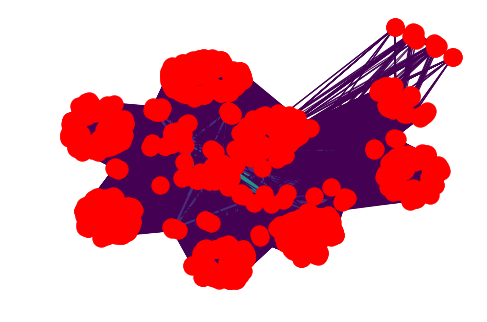

In [23]:
make_draw_projected_graph(character_graph, False)

<h3> Projected Graph: Season</h3>

In [ ]:
################
## sites
##############
season_graph = bi.weighted_projected_graph(characters_season, list(sf_cast_group.season.values), ratio=False)

In [ ]:
season_graph = list(nx.connected_component_subgraphs(season_graph))[0]

In [ ]:
centrality_measures(season_graph) #takes awhile to run

In [ ]:
make_draw_projected_graph(season_graph, True)

<h3> Island Method</h3>

Let's pair down each of the projected graphs using the island method.

In [ ]:
#users
character_island = island_method(character_graph)

In [ ]:
print_island_info(character_island)

In [ ]:
show_island_graphs(character_island,1,True)

In [ ]:
show_island_graphs(character_island,2,True)

In [ ]:
show_island_graphs(character_island,3,True)

In [ ]:
show_island_graphs(character_island,4,True)

In [ ]:
show_island_graphs(character_island,5,True)

In [ ]:
show_island_graphs(character_island,6,True)

In [ ]:
show_island_graphs(character_island,7,True)

In [ ]:
## season
season_island = island_method(season_graph)

For the site graph, we see that we can reduce from 120, to 9, 6, 3, 2, 2 nodes by increasing the weight threshold.  The graph always has 1 connected component.

In [ ]:
print "Threshold, Nodes, Edges, Number of Connected Components"
for i in season_island:
    print i[0], nx.number_of_nodes(i[1]), nx.number_of_edges(i[1]), nx.number_connected_components(i[1])

In [ ]:
show_island_graphs(season_island,1,True)

In [ ]:
show_island_graphs(season_island,2,True)

In [ ]:
show_island_graphs(season_island,3,True)

In [ ]:
show_island_graphs(season_island,4,True)

In [ ]:
show_island_graphs(season_island,5,True)

<h2>Character by Scene Number</h2>

In [ ]:
sf_dialgoue_sub.head(5)

In [ ]:
#group data
sf_dialgoue_sub_group = sf_dialgoue_sub.groupby(['Character','SceneNum'], as_index=False).count()
sf_dialgoue_sub_group  = sf_dialgoue_sub_group [['Character','SceneNum', 'SEID']]
sf_dialgoue_sub_group.columns = ['Character','SceneNum', 'Counts']

In [ ]:
sf_dialgoue_sub_group.head(5)

In [ ]:
#draw graph
character_scene = make_draw_graph("Characters and Scene", list(sf_dialgoue_sub_group.Character.values) + list(sf_dialgoue_sub_group.SceneNum.values),sf_dialgoue_sub_group, False)

<h3> Projected Graph: Character to Scene</h3>

In [ ]:
character_scene_graph = bi.weighted_projected_graph(character_scene, list(sf_dialgoue_sub_group.Character.values), ratio=False)

In [ ]:
centrality_measures(character_scene_graph ) #takes awhile to run

In [ ]:
make_draw_projected_graph(character_scene_graph, False)

<h3>Island</h3>

In [ ]:
#users
character_scene_island = island_method(character_scene_graph)
print_island_info(character_scene_island)

In [ ]:
show_island_graphs(character_scene_island,1,True)

In [ ]:
show_island_graphs(character_scene_island,3,True)

In [ ]:
show_island_graphs(character_scene_island,5,True)

<h2> 3. Directors and Season </h2>


In [24]:
sf_metadata.head(5)

,AirDate,Director,Episode,SEID,Season,Title
0,"July 5, 1989",Art Wolff,1,S01E00,1,"Good News, Bad News"
1,"May 31, 1990",Tom Cherones,1,S01E01,1,The Stakeout
2,"June 7, 1990",Tom Cherones,2,S01E02,1,The Robbery
3,"June 14, 1990",Tom Cherones,3,S01E03,1,Male Unbonding
4,"June 21, 1990",Tom Cherones,4,S01E04,1,The Stock Tip


In [25]:
sf_metadata_group = sf_metadata.groupby(['Director','Season'], as_index=False).count()
sf_metadata_group = sf_metadata_group[['Director','Season', 'SEID']]
sf_metadata_group.columns = ['Director','Season', 'Counts']
sf_metadata_group.head(5)

,Director,Season,Counts
0,Andy Ackerman,6,21
1,Andy Ackerman,7,24
2,Andy Ackerman,8,21
3,Andy Ackerman,9,21
4,Art Wolff,1,1


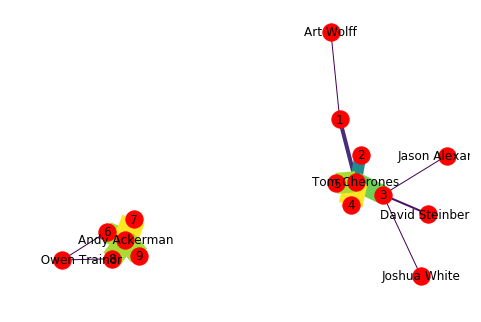

In [26]:
#draw actor and season graph
directors_season = make_draw_graph("Directors and Season", list(sf_metadata_group.Director.values) + list(sf_metadata_group.Season.values),sf_metadata_group, True)

Number of Nodes:
7

Number of Edges:
8

Degree:
[('Tom Cherones', 4), ('David Steinberg', 3), ('Jason Alexander', 3), ('Joshua White', 3), ('Andy Ackerman', 1), ('Art Wolff', 1), ('David Owen Trainor', 1)]

Closeness:
[('Tom Cherones', 0.6666666666666666), ('David Steinberg', 0.5333333333333333), ('Jason Alexander', 0.5333333333333333), ('Joshua White', 0.5333333333333333), ('Art Wolff', 0.38095238095238093), ('Andy Ackerman', 0.16666666666666666), ('David Owen Trainor', 0.16666666666666666)]

Betweenness:
[('Tom Cherones', 0.2), ('Andy Ackerman', 0.0), ('Art Wolff', 0.0), ('David Owen Trainor', 0.0), ('David Steinberg', 0.0), ('Jason Alexander', 0.0), ('Joshua White', 0.0)]

Eigenvector:
[('Tom Cherones', 0.5235630239710829), ('David Steinberg', 0.48204443864828317), ('Jason Alexander', 0.48204443864828317), ('Joshua White', 0.48204443864828317), ('Art Wolff', 0.1696503387049744), ('Andy Ackerman', 2.4826834530544244e-06), ('David Owen Trainor', 2.4826834530544244e-06)]

Pagerank:
[('

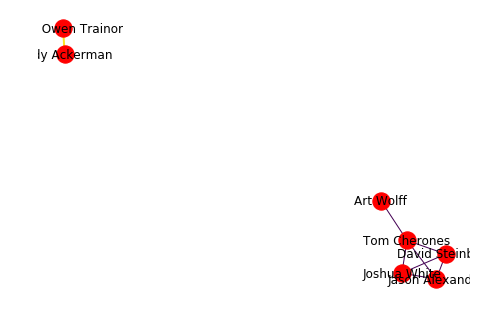

In [28]:
#projected director
director_graph = bi.weighted_projected_graph(directors_season, list(sf_metadata_group.Director.values), ratio=False)
centrality_measures(director_graph) #takes awhile to run
make_draw_projected_graph(director_graph, True)

Number of Nodes:
9

Number of Edges:
16

Degree:
[(1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (6, 3), (7, 3), (8, 3), (9, 3)]

Closeness:
[(1, 0.5), (2, 0.5), (3, 0.5), (4, 0.5), (5, 0.5), (6, 0.375), (7, 0.375), (8, 0.375), (9, 0.375)]

Betweenness:
[(1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0)]

Eigenvector:
[(1, 0.4472135954430211), (2, 0.4472135954430211), (3, 0.4472135954430211), (4, 0.4472135954430211), (5, 0.4472135954430211), (6, 7.978557153034853e-06), (7, 7.978557153034853e-06), (8, 7.978557153034853e-06), (9, 7.978557153034853e-06)]

Pagerank:
[(6, 0.12489850979595186), (8, 0.12489850979595185), (1, 0.1111111111111111), (2, 0.1111111111111111), (3, 0.1111111111111111), (4, 0.1111111111111111), (5, 0.1111111111111111), (7, 0.09732371242627035), (9, 0.09732371242627033)]


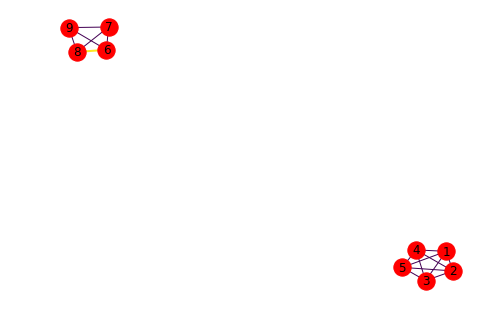

In [29]:
#projected season
director_season_graph = bi.weighted_projected_graph(directors_season, list(sf_metadata_group.Season.values), ratio=False)
centrality_measures(director_season_graph) #takes awhile to run
make_draw_projected_graph(director_season_graph, True)

<h2>4. Writers and Season </h2>


In [30]:
sf_writers.head(5)

,Writers,SEID
0,Larry David,S01E00
1,Jerry Seinfeld,S01E00
2,Larry David,S01E01
3,Jerry Seinfeld,S01E01
4,Matt Goldman,S01E02


In [31]:
#reference: https://pandas.pydata.org/pandas-docs/stable/10min.html
sf_writers_episode = pd.DataFrame(sf_writers['SEID'].str.split("E").tolist(), columns = ['season','episode'])
sf_writers = sf_writers.join(sf_writers_episode)
sf_writers.head(5)

,Writers,SEID,season,episode
0,Larry David,S01E00,S01,00
1,Jerry Seinfeld,S01E00,S01,00
2,Larry David,S01E01,S01,01
3,Jerry Seinfeld,S01E01,S01,01
4,Matt Goldman,S01E02,S01,02


In [33]:
sf_writers_group = sf_writers.groupby(['Writers','season'], as_index=False).count()
sf_writers_group = sf_writers_group[['Writers','season', 'episode']]
sf_writers_group.columns = ['Writers','season', 'Counts']
sf_writers_group.head(5)

,Writers,season,Counts
0,Alec Berg,S06,3
1,Alec Berg,S07,3
2,Alec Berg,S08,3
3,Alec Berg,S09,5
4,Andy Cowan,S05,1


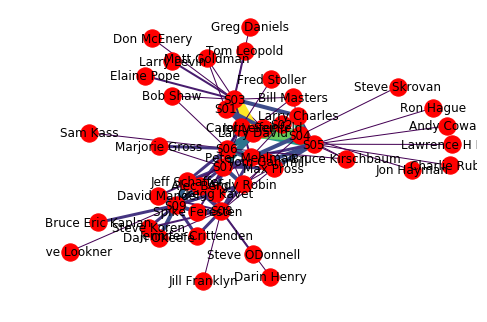

In [35]:
#draw actor and season graph
writers_season = make_draw_graph("Writers and Season", list(sf_writers_group.Writers.values) + list(sf_writers_group.season.values),sf_writers_group, True)

Number of Nodes:
39

Number of Edges:
356

Degree:
[('Peter Mehlman', 38), ('Larry David', 35), ('Andy Robin', 32), ('Jerry Seinfeld', 30), ('Max Pross', 28), ('Tom Gammill', 28), ('Alec Berg', 25), ('Gregg Kavet', 25), ('Jeff Schaffer', 25), ('Bill Masters', 24)]

Closeness:
[('Peter Mehlman', 1.0), ('Larry David', 0.926829268292683), ('Andy Robin', 0.8636363636363636), ('Jerry Seinfeld', 0.8260869565217391), ('Max Pross', 0.7916666666666666), ('Tom Gammill', 0.7916666666666666), ('Alec Berg', 0.7450980392156863), ('Gregg Kavet', 0.7450980392156863), ('Jeff Schaffer', 0.7450980392156863), ('Bill Masters', 0.7307692307692307)]

Betweenness:
[('Peter Mehlman', 0.1363692297902824), ('Larry David', 0.09548323100954682), ('Andy Robin', 0.05443466364518998), ('Jerry Seinfeld', 0.05249323144059985), ('Max Pross', 0.028085929401718876), ('Tom Gammill', 0.028085929401718876), ('Bill Masters', 0.026092257671205044), ('Larry Charles', 0.023847908058434376), ('Bob Shaw', 0.0182076813655761), ('Al

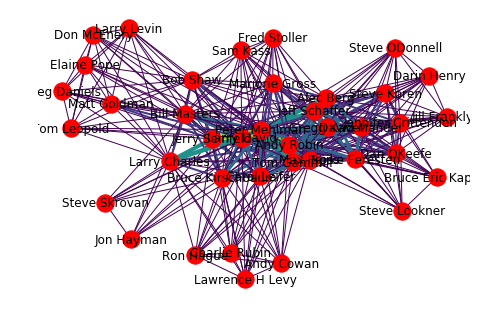

In [37]:
#projected writers
writer_graph = bi.weighted_projected_graph(writers_season, list(sf_writers_group.Writers.values), ratio=False)
centrality_measures(writer_graph) #takes awhile to run
make_draw_projected_graph(writer_graph, True)

In [39]:
#island on proejcted writers
writer_island = island_method(writer_graph)
print_island_info(writer_island)

Threshold, Nodes, Edges, Number of Connected Components
1 21 120 1
2 15 60 1
3 10 23 1
4 4 5 1
5 4 4 1
6 3 2 1


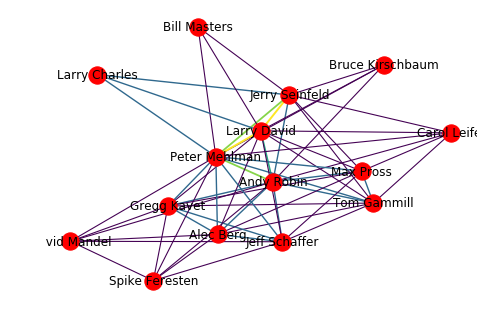

In [40]:
show_island_graphs(writer_island,1,True)

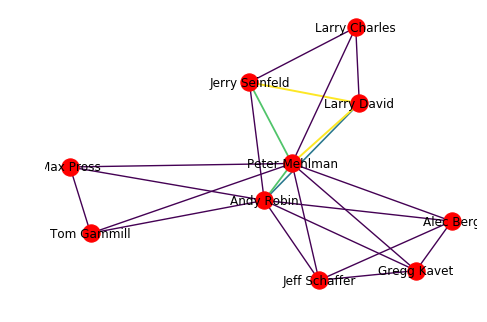

In [41]:
show_island_graphs(writer_island,2,True)

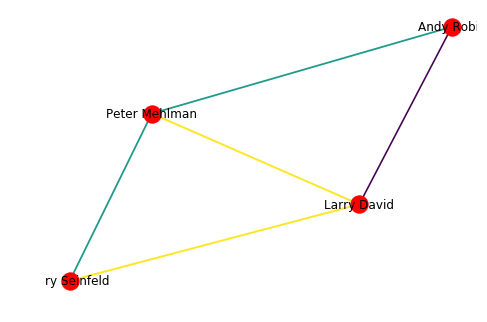

In [42]:
show_island_graphs(writer_island,3,True)

Number of Nodes:
9

Number of Edges:
35

Degree:
[('S02', 8), ('S03', 8), ('S04', 8), ('S05', 8), ('S06', 8), ('S07', 8), ('S09', 8), ('S01', 7), ('S08', 7)]

Closeness:
[('S02', 1.0), ('S03', 1.0), ('S04', 1.0), ('S05', 1.0), ('S06', 1.0), ('S07', 1.0), ('S09', 1.0), ('S01', 0.8888888888888888), ('S08', 0.8888888888888888)]

Betweenness:
[('S02', 0.00510204081632653), ('S03', 0.00510204081632653), ('S04', 0.00510204081632653), ('S05', 0.00510204081632653), ('S06', 0.00510204081632653), ('S07', 0.00510204081632653), ('S09', 0.00510204081632653), ('S01', 0.0), ('S08', 0.0)]

Eigenvector:
[('S02', 0.34074955749202834), ('S03', 0.34074955749202834), ('S04', 0.34074955749202834), ('S05', 0.34074955749202834), ('S06', 0.34074955749202834), ('S07', 0.34074955749202834), ('S09', 0.34074955749202834), ('S01', 0.30596419192685614), ('S08', 0.30596419192685614)]

Pagerank:
[('S06', 0.1537352784541297), ('S07', 0.1503520305707618), ('S05', 0.125511222616213), ('S09', 0.11524573314845227), ('S08',

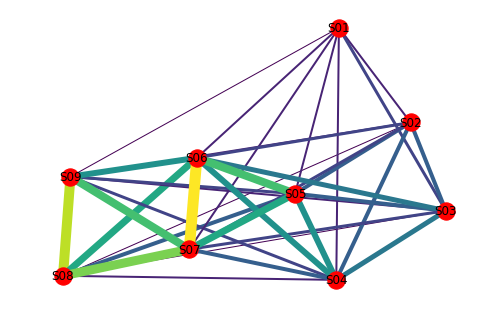

In [38]:
#projected season
writer_season_graph = bi.weighted_projected_graph(writers_season, list(sf_writers_group.season.values), ratio=False)
centrality_measures(writer_season_graph) #takes awhile to run
make_draw_projected_graph(writer_season_graph, True)

<h2>5. Writers, Directors, and Cast</h2>

In [44]:
sf_writers.head(5), sf_metadata.head(5), sf_cast.head(5)

(          Writers    SEID season episode
 0     Larry David  S01E00    S01      00
 1  Jerry Seinfeld  S01E00    S01      00
 2     Larry David  S01E01    S01      01
 3  Jerry Seinfeld  S01E01    S01      01
 4    Matt Goldman  S01E02    S01      02,
          AirDate      Director  Episode    SEID  Season                Title
 0   July 5, 1989     Art Wolff        1  S01E00       1  Good News, Bad News
 1   May 31, 1990  Tom Cherones        1  S01E01       1         The Stakeout
 2   June 7, 1990  Tom Cherones        2  S01E02       1          The Robbery
 3  June 14, 1990  Tom Cherones        3  S01E03       1       Male Unbonding
 4  June 21, 1990  Tom Cherones        4  S01E04       1        The Stock Tip,
               Actor        Character    SEID season episode
 0    Jerry Seinfeld   Jerry Seinfeld  S01E00    S01      00
 1   Jason Alexander  George Costanza  S01E00    S01      00
 2  Michael Richards          Kessler  S01E00    S01      00
 3    Lee Garlington           Cla

In [62]:
#join writers, directors, actors together by SEID
sf_all_people = sf_metadata[['Director', 'SEID']]
sf_writers_sub = sf_writers[['Writers','SEID']]
sf_all_people = sf_all_people.set_index('SEID').join(sf_writers_sub.set_index('SEID'), on='SEID', how='outer')
sf_cast_sub = sf_cast[['Actor', 'SEID']]
sf_all_people = sf_all_people.join(sf_cast_sub.set_index('SEID'), on='SEID', how='outer')
sf_all_people.head(5)

,Director,Writers,Actor
SEID,,,
S01E00,Art Wolff,Larry David,Jerry Seinfeld
S01E00,Art Wolff,Larry David,Jason Alexander
S01E00,Art Wolff,Larry David,Michael Richards
S01E00,Art Wolff,Larry David,Lee Garlington
S01E00,Art Wolff,Larry David,Pamela Brull


In [65]:
director_writer_group = sf_all_people.groupby(['Director','Writers'], as_index=False).count()
director_writer_group = director_writer_group[['Director','Writers', 'Actor']]
director_writer_group.columns = ['Director','Writers', 'Counts']
director_writer_group.head(5)

,Director,Writers,Counts
0,Andy Ackerman,Alec Berg,215
1,Andy Ackerman,Andy Robin,144
2,Andy Ackerman,Bill Masters,9
3,Andy Ackerman,Bob Shaw,9
4,Andy Ackerman,Bruce Eric Kaplan,47


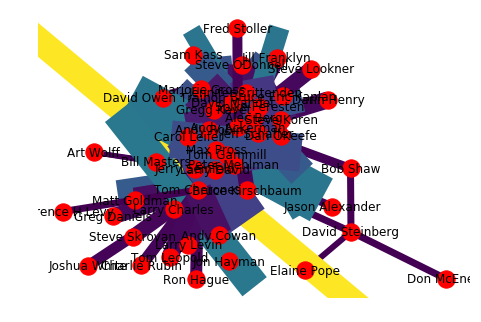

In [67]:
#draw actor and season graph
director_writer = make_draw_graph("Directors and Writers", list(director_writer_group.Director.values) + list(director_writer_group.Writers.values),director_writer_group, True)

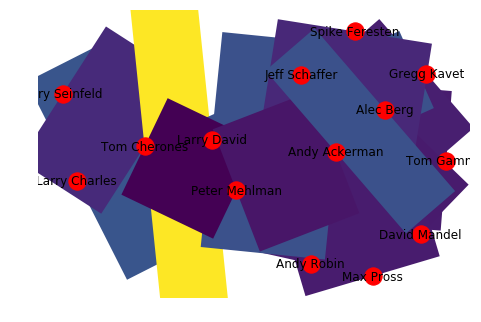

In [80]:
director_writer_sub = director_writer_group[director_writer_group['Counts']>100]
#director_writer_sub.head(5)
director_writer_sub_graph = make_draw_graph("Directors and Writers", list(director_writer_sub.Director.values) + list(director_writer_sub.Writers.values),director_writer_sub, True)

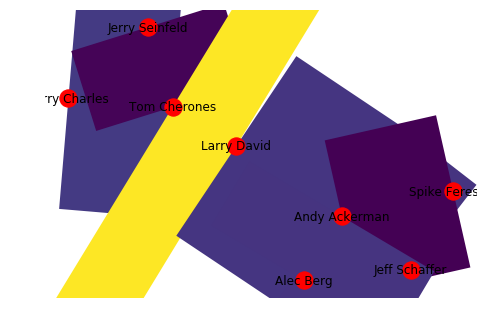

In [81]:
director_writer_sub = director_writer_group[director_writer_group['Counts']>150]
#director_writer_sub.head(5)
director_writer_sub_graph = make_draw_graph("Directors and Writers", list(director_writer_sub.Director.values) + list(director_writer_sub.Writers.values),director_writer_sub, True)

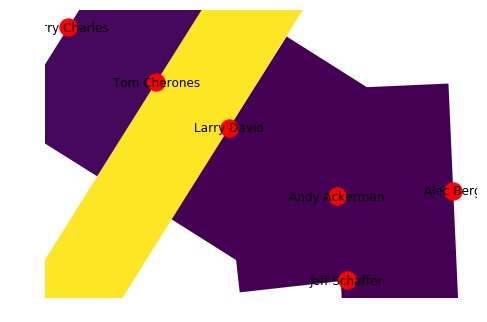

In [82]:
director_writer_sub = director_writer_group[director_writer_group['Counts']>200]
#director_writer_sub.head(5)
director_writer_sub_graph = make_draw_graph("Directors and Writers", list(director_writer_sub.Director.values) + list(director_writer_sub.Writers.values),director_writer_sub, True)

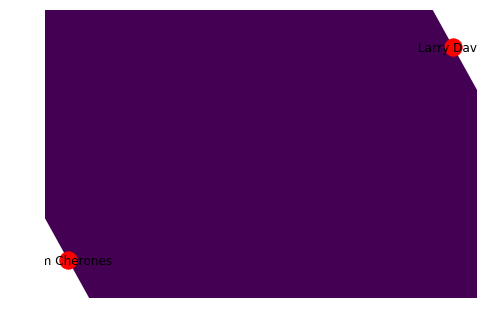

In [83]:
director_writer_sub = director_writer_group[director_writer_group['Counts']>300]
#director_writer_sub.head(5)
director_writer_sub_graph = make_draw_graph("Directors and Writers", list(director_writer_sub.Director.values) + list(director_writer_sub.Writers.values),director_writer_sub, True)

<h2> Conclusion </h2>
